# Example of a single planet system fit: Kepler 5

In [1]:
import exoplanet as xo
import lightkurve as lk
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from astropy.time import Time

import sys
sys.path.append("../helpers")
import data
import xo_archive

%config InlineBackend.figure_format = "retina"

# Get the data

Get all Kepler data using Lightkurve.

In [14]:
%%time
flat_lc = data.get_flattened_lc("Kepler-5", mission="Kepler", exptime=1800)

CPU times: user 11.4 s, sys: 17.3 s, total: 28.7 s
Wall time: 6.73 s


# Remove outliers
Next we can remove outliers from the data, this is important but we have to be careful to avoid the transits. First we need the planet data

In [102]:
planet_parameters = xo_archive.get_exoplanet_parameters("kepler-5 ", which="composite")
n_planets = len(planet_parameters)
param_lists = xo_archive.transpose_parameters(planet_parameters)

In [92]:
lc = data.remove_outliers(flat_lc, param_lists["pl_orbper"], param_lists["pl_tranmid"], param_lists["pl_trandur"])

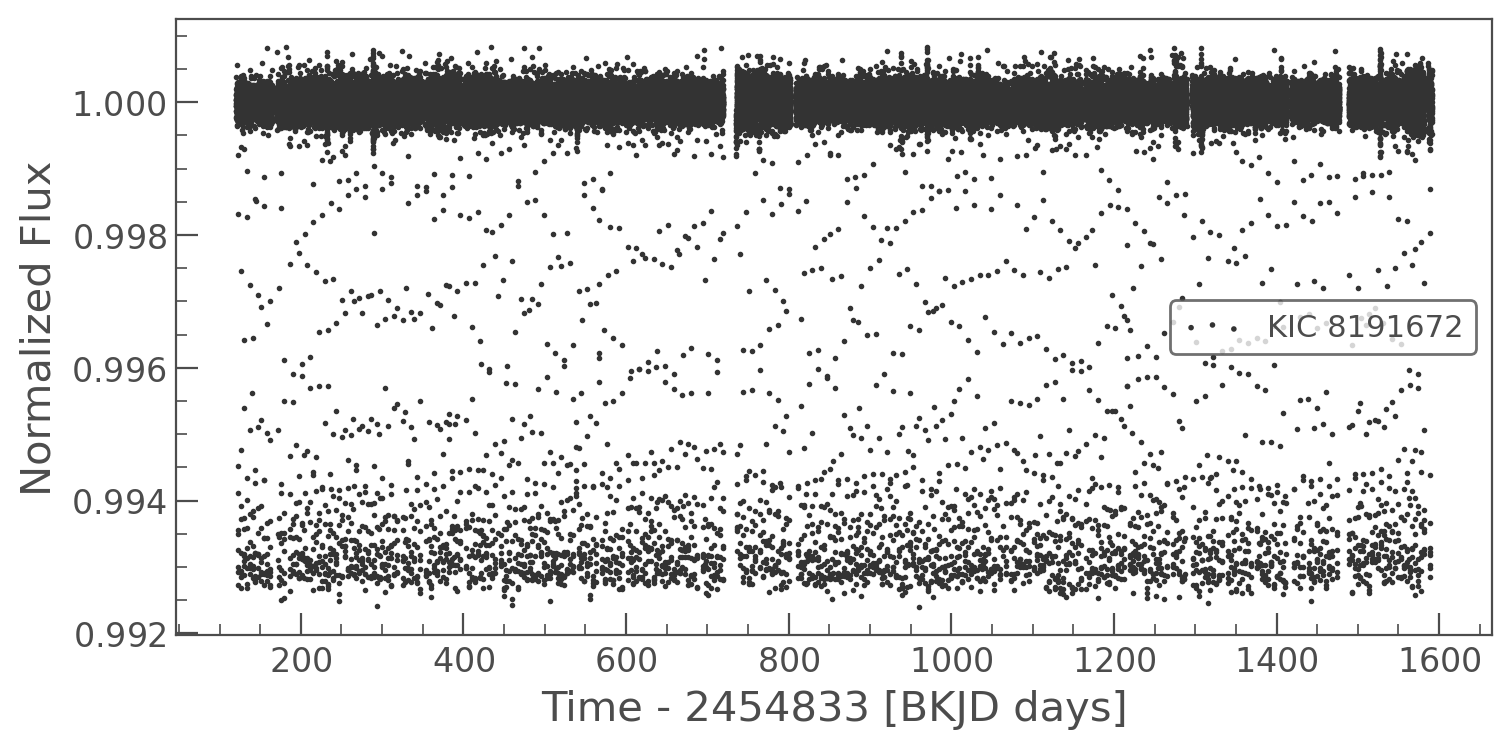

In [93]:
lc.scatter()
plt.show()

## Folded lightcurves

Now we can try folding the lightkurves at the different planet periods to check that they look good

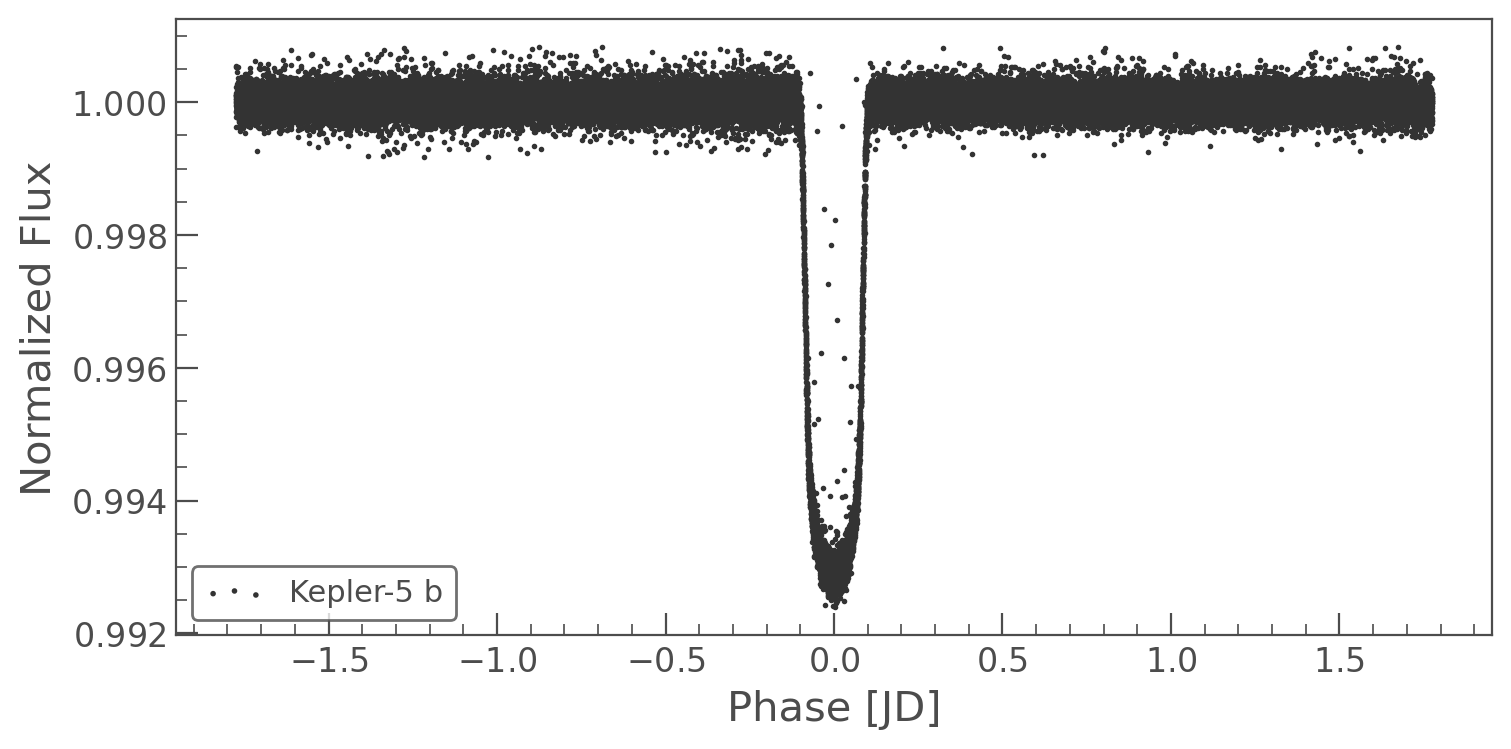

In [43]:
for i in range(len(planet_parameters)):
    ax = lc.fold(period=planet_parameters[i]["pl_orbper"],
                 epoch_time=Time(planet_parameters[i]["pl_tranmid"] * u.day, format="jd").bkjd).scatter(label=planet_parameters[i]["pl_name"])
    plt.show()

# Now to fit things

In [95]:
import fit

In [96]:
map_soln = fit.optimise_model(lc, param_lists)

optimizing logp for variables: [log_rho_star, b, r, u, logP, t0, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 451011.55866917263 -> 461116.34094218456


# Let's see how the fit looks

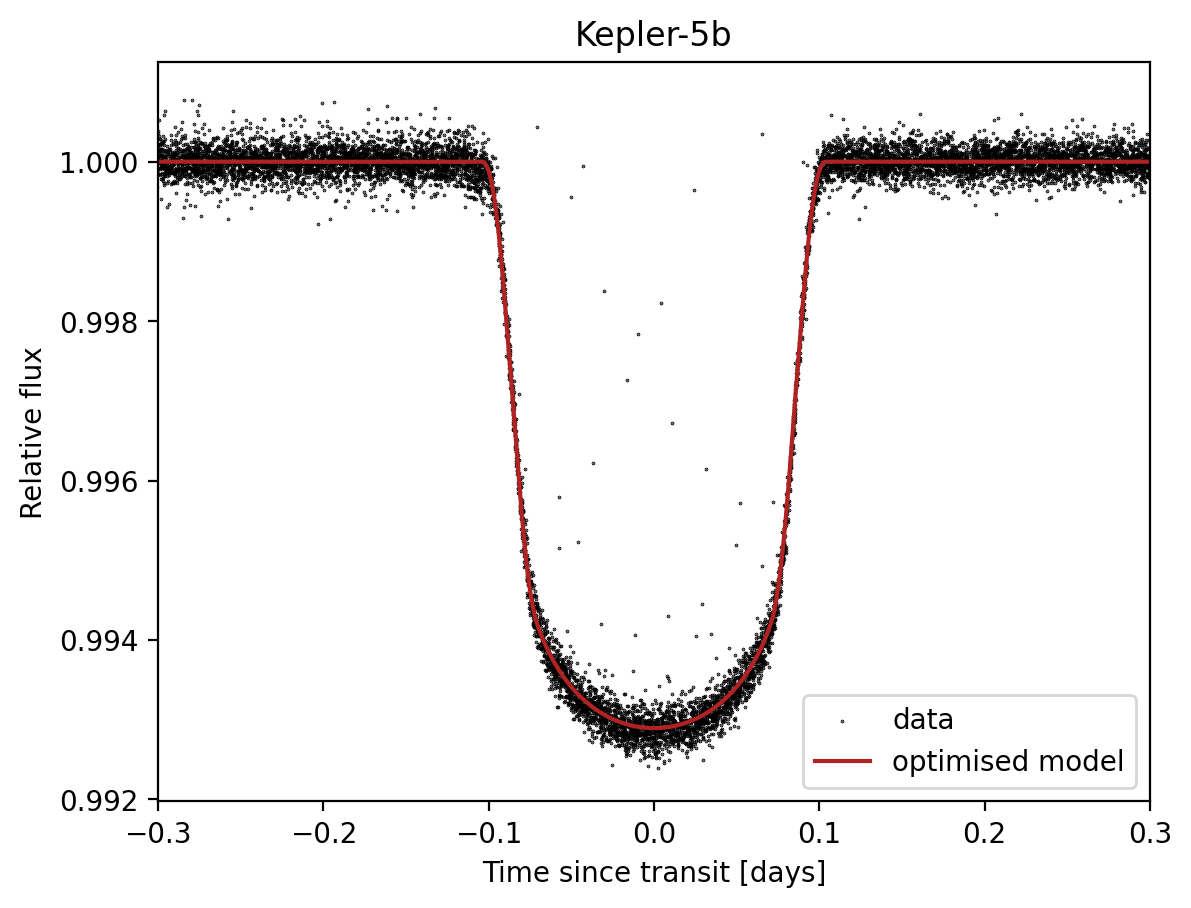

In [104]:
t = lc["time"].value

plt.figure()

p = map_soln["period"][0]
t0 = map_soln["t0"][0]

# Plot the folded data
x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
plt.scatter(
    x_fold, y, label="data", zorder=-1000, s=0.1, color="black"
)

# Plot the folded model within 0.3 days of the transit
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = map_soln["light_curves"][inds, 0] + map_soln["mean"]
plt.plot(x_fold[inds], pred, color="firebrick", label="optimised model")

plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5 * p, 0.5 * p)
plt.xlabel("Time since transit [days]")
plt.ylabel("Relative flux")
plt.title(f"Kepler-5b")
plt.xlim(-0.3, 0.3)
plt.show()